# **Fine-Tuning BERT for Spam Text Classification**

## **Main References:**
* https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
* https://gradio.app/getting_started

**Transfer Learning in NLP:**

Transfer learning is a technique where a deep learning model trained on a large dataset is used to perform similar tasks on another dataset. This deep learning model is called a pre-trained model.

**Background and Setting:**
* Neural nets like RNN, LSTM and CNNs have shown good performance in solving several NLP tasks like text classification, language modeling, machine translation, etc.
* However these models perform better in computer vision rather than in NLP
* The main reason being lack of labeled text datasets.
* Another important reason for NLP lagging behind computer vision was the lack of transfer learning in NLP.
* When the transformer model was introduced by Google, transfer learning in NLP is helping in solving many tasks with state of the art performance

**Transfer Learning in NLP**

* Most tasks in NLP such as text classification, language modeling, machine translation, etc. are sequence modeling tasks.
* The traditional machine learning models and neural networks cannot capture the sequential information present in the text
* Therefore, RNNs and LSTMs were used because these architectures can model sequential information present in the text.
* One major issue is that RNNs and LSTMs can not be parallelized because they take one input at a time. So, it will pass through the sequence token by token. Hence, training such a model on a big dataset will take a lot of time.
* The concept of attention helped resolve this issue by Google. This turned out to be one of of the most important milestone in NLP

**Advantages of using Transformers in NLP**

* These models take the entire sequence as input in one go which is a big improvement over RNNs because now the model can be accelerated by the GPUs. 
* We don’t need labeled data to pre-train these models

***BERT and GPT-2 are the most popular transformer-based models***

This notebook will focus on using pre-trained BERT model to perform text classification



## **BERT**

* BERT stands for Bidirectional Encoder Representations from Transformers. 
* It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. 
* As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks
* BERT is based on the Transformer architecture
* BERT is pre-trained on a large corpus of unlabelled text including the entire Wikipedia (that’s 2,500 million words!) and Book Corpus (800 million words).



## **Dataset**
https://raw.githubusercontent.com/prateekjoshi565/Fine-Tuning-BERT/master/spamdata_v2.csv

## **Task**

Spam Classification task for messages



## **Install Transformers Library**

In [1]:
## This library will let us import a wide range of transformer-based pre-trained models.
!pip install transformers

     |████████████████████████████████| 3.1 MB 6.9 MB/s 
     |████████████████████████████████| 596 kB 39.2 MB/s 
     |████████████████████████████████| 3.3 MB 20.3 MB/s 
     |████████████████████████████████| 895 kB 22.6 MB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## **Installing TensorBoard**

In [31]:
!pip install tensorboard

In [52]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

In [3]:
## Import other important libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

## **Load Dataset**

In [8]:
## Load Dataset
df = pd.read_csv("/content/spamdata_v2.txt")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.shape

(5572, 2)

In [10]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

## **Split train dataset into train, validation and test sets**

In [11]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## **Import BERT Model and BERT Tokenizer**

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [13]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [14]:
# output
print(sent_id)


{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


The output is a dictionary of two items.

‘input_ids’ contains the integer sequences of the input sentences. The integers 101 and 102 are special tokens. We add them to both the sequences, and 0 represents the padding token.
‘attention_mask’ contains 1’s and 0’s. It tells the model to pay attention to the tokens corresponding to the mask value of 1 and ignore the rest.


## **Tokenization**

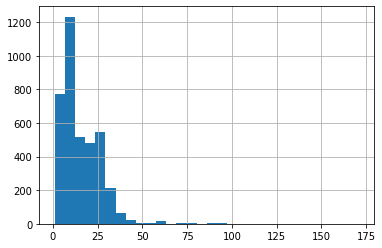

In [15]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [16]:
max_seq_len = 25

In [17]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## **Convert Integer Sequences to Tensors**

In [18]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## **Create DataLoaders**

The dataloaders will pass batches of train data and validation data as input to the model during the training phase.

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## **Freeze BERT Parameters**

In [20]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## **Define Model Architecture**

In [21]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      # _, cls_hs = self.bert(sent_id, attention_mask=mask)
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x


In [22]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [23]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)


## **Find Class Weights:** To handle the class imbalance

In [24]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [25]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

## **Fine-Tune BERT**

In [26]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

## **Evaluate the model**

In [27]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## **Model Training**

In [29]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    ##Adding logs to TensorBoard
    tb.add_scalar("Training Loss", train_loss, epoch)
    tb.add_scalar("Validation Loss", valid_loss, epoch)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
tb.close()


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.507
Validation Loss: 0.288

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.361
Validation Loss: 0.268

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.259
Validation Loss: 0.193

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.242
Validation Loss: 0.273

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.210
Validation Loss: 0.152

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.378
Validation Loss: 0.216

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.225
Validation Loss: 0.171

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.236
Validat

In [34]:
# from keras.callbacks import TensorBoard
# from time import time

# # Create a TensorBoard instance with the path to the logs directory
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [49]:
%load_ext tensorboard

In [53]:
import tensorflow as tf

In [54]:
!tensorboard --logdir runs

2021-10-30 03:17:25.531554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 03:17:25.541361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 03:17:25.542262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL

## **Load Saved Model**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))


<All keys matched successfully>

## **Getting Predictions for Test Data**

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.83      0.96      0.89       112

    accuracy                           0.97       836
   macro avg       0.91      0.96      0.93       836
weighted avg       0.97      0.97      0.97       836



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,702,22
1,5,107


In [ ]:
# sample data
text = ["this is a bert model tutorial"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
test_seq = torch.tensor(sent_id['input_ids'])
test_mask = torch.tensor(sent_id['attention_mask'])

In [ ]:
test_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
# pred_test = model(sent_id, test_mask)

pred_test = model(test_seq.to(device), test_mask.to(device))
pred_test = pred_test.detach().cpu().numpy()
pred_test = np.argmax(pred_test, axis = 1)

In [ ]:
pred_test

array([0])

# **Gradio**

In [ ]:
!pip install -q gradio

     |████████████████████████████████| 2.0 MB 14.6 MB/s 
     |████████████████████████████████| 1.9 MB 38.4 MB/s 
     |████████████████████████████████| 206 kB 71.2 MB/s 
     |████████████████████████████████| 63 kB 3.3 MB/s 
     |████████████████████████████████| 3.5 MB 63.2 MB/s 
     |████████████████████████████████| 961 kB 73.4 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
# from urllib.request import urlretrieve
import gradio as gr

def spam_classification(text):
    arr =[]
    arr.append(text)
    sent_id = tokenizer.batch_encode_plus(arr, padding=True, return_token_type_ids=False)
    test_seq = torch.tensor(sent_id['input_ids'])
    test_mask = torch.tensor(sent_id['attention_mask'])
    pred_test = model(test_seq.to(device), test_mask.to(device))
    pred_test = pred_test.detach().cpu().numpy()
    pred_test = np.argmax(pred_test, axis = 1)
    # print(pred_test)
    # arr.append(pred_test)
    return pred_test

output_component = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=spam_classification, 
             inputs="textbox", 
             outputs='textbox').launch(share=True);

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://26029.gradio.app


In [ ]:
import tensorflow as tf
import numpy as np
# from urllib.request import urlretrieve
import gradio as gr

def spam_classification(text):
    arr =[]
    arr.append(text)
    sent_id = tokenizer.batch_encode_plus(arr, padding=True, return_token_type_ids=False)
    test_seq = torch.tensor(sent_id['input_ids'])
    test_mask = torch.tensor(sent_id['attention_mask'])
    pred_test = model(test_seq.to(device), test_mask.to(device))
    pred_test = pred_test.detach().cpu().numpy()
    pred_test = np.argmax(pred_test, axis = 1)
    # print(pred_test)
    # arr.append(pred_test)
    return pred_test

output_component = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=spam_classification, 
             inputs="textbox", 
             outputs='textbox').launch(share=True);

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://20508.gradio.app
